# pySCENIC protocol: iPSC to iLSC

May 2024

Adapted by: Julian Arts

Using environment: JA_scenic

Dataset: iPSC differentiation scRNA-seq object

In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from pathlib import Path
import sys
#from MulticoreTSNE import MulticoreTSNE as TSNE

In [2]:
# Convert meta-atlas to loom file
dir_disk = "/mnt/s/"

# Load in meta-atlas file
adata = sc.read_h5ad(f'{dir_disk}Radboud/data/scRNAseq_ipsc/correct/louvain_ipsc_scrnaseq.h5ad')

# Convert if nessesary
if not os.path.exists(f"{dir_disk}Radboud/data/scRNAseq_ipsc/correct/ipsc_louvain.loom"):
    adata.write_loom(f"{dir_disk}Radboud/data/scRNAseq_ipsc/correct/ipsc_louvain.loom")

In [3]:
# set a working directory
wdir = f"{dir_disk}Radboud/data/scRNAseq_ipsc/correct/scenic/05042024" + "/"
Path(f"{dir_disk}Radboud/data/scRNAseq_ipsc/correct/scenic/05042024").mkdir(parents=True, exist_ok=True) 
os.chdir( wdir )

# # path to loom file with basic filtering applied (this will be created in the "initial filtering" step below). Optional.
f_loom_path_scenic = f"{dir_disk}Radboud/data/scRNAseq_ipsc/correct/scenic/05042024/ipsc_filtered_scenic.loom"

# path to anndata object, which will be updated to store Scanpy results as they are generated below
f_anndata_path = f"{dir_disk}Radboud/data/scRNAseq_ipsc/correct/scenic/05042024/anndata_meta_scenic.h5ad"

# path to pyscenic output
f_pyscenic_output = f"{dir_disk}Radboud/data/scRNAseq_ipsc/correct/scenic/05042024/pyscenic_output.loom"

# loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = f'{dir_disk}Radboud/data/scRNAseq_ipsc/correct/scenic/05042024/meta_scenic_integrated-output.loom'

In [ ]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

-----
anndata     0.10.6
scanpy      1.10.0
-----
PIL                 10.3.0
asttokens           NA
cloudpickle         3.0.0
colorama            0.4.6
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
cytoolz             0.12.3
dask                2023.12.1
dateutil            2.9.0
debugpy             1.8.1
decorator           5.1.1
executing           2.0.1
h5py                3.10.0
ipykernel           6.29.3
jedi                0.19.1
jinja2              3.1.3
joblib              1.3.2
kiwisolver          1.4.5
legacy_api_wrap     NA
llvmlite            0.42.0
loompy              3.0.7
lz4                 4.3.3
markupsafe          2.1.5
matplotlib          3.8.3
mpl_toolkits        NA
natsort             8.4.0
numba               0.59.1
numexpr             2.10.0
numpy               1.23.5
numpy_groupies      0.10.2
packaging           24.0
pandas              1.5.3
parso               0.8.4
pickleshare         0.7.5
platformdirs        4.2.0
prompt_toolk

In [5]:
# Set maximum number of jobs for Scanpy.
sc.settings.njobs = 10

### Finalize the selected filters

Update the anndata file, to be used for further processing, clustering, visualization, etc..

Output the basic filtered expression matrix to a loom file.  

This can also be used in the command-line pySCENIC steps, for example, or as an input to the Nextflow pipeline.

In [6]:
adata = adata.raw.to_adata()
adata.var_names

Index(['TRE-CTC2-1', 'TRL-CAA4-1', 'PGBD2', 'ZNF692', 'ZNF672', 'MIR3124',
       'SH3BP5L', 'LYPD8', 'LYPD9P', 'OR14I1',
       ...
       'GLUD2', 'CT47A1', 'CT47A2', 'CT47A3', 'CT47A4', 'CT47A5', 'CT47A11',
       'CT47B1', 'C1GALT1C1', 'MCTS1'],
      dtype='object', length=23713)

In [7]:
adata.obs_names

Index(['GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18',
       'GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24',
       'GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22',
       'GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15',
       'GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_J17',
       'GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_E9',
       'GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_M17',
       'GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_G11',
       'GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L11',
       'GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_I16',
       ...
       'GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1688_Z22_S18_J10',
       'GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1688_Z22_S18_M20',
       'GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1688_Z22_S18_H5',
       'GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1688_Z22_S18_F8',
       'GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1688_Z22_S18_C10',
       'GRCh38.p13ERCCreporter_ext_ba

In [8]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    #"nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    #"nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}

## SCENIC steps

### STEP 1: Gene regulatory network inference, and generation of co-expression modules
#### Phase Ia: GRN inference using the GRNBoost2 algorithm

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system. We use the counts matrix (without log transformation or further processing) from the loom file we wrote earlier.
_Output:_ List of adjacencies between a TF and its targets stored in `ADJACENCIES_FNAME`.

In [9]:
# transcription factors list
f_tfs = f"{dir_disk}Radboud/data/scRNAseq_ipsc/correct/scenic/05042024/allTFs_hg38.txt" # human

In [10]:
f_loom_path_scenic = f"{dir_disk}Radboud/data/scRNAseq_ipsc/correct/scenic/05042024/ipsc_louvain.loom"
if not os.path.exists(f"{dir_disk}Radboud/data/scRNAseq_ipsc/correct/scenic/05042024/ipsc_louvain.loom"): 
    lp.create(f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)

In [11]:
!pyscenic grn {f_loom_path_scenic} {f_tfs} -o adj.csv --num_workers 12


2024-04-05 18:27:09,267 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2024-04-05 18:27:12,622 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
preparing dask client
parsing input
creating dask graph
12 partitions
computing dask graph
/home/julian/.conda/envs/JA_scenic/lib/python3.12/site-packages/distributed/client.py:3162: UserWarning: Sending large graph of size 659.65 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
not shutting down client, client was created externally
finished

2024-04-05 19:01:05,760 - pyscenic.cli.pyscenic - INFO - Writing results to file.


read in the adjacencies matrix:

In [11]:
adjacencies = pd.read_csv(f"{dir_disk}Radboud/data/scRNAseq_ipsc/correct/scenic/05042024"  + "/adj.csv", index_col=False, sep=',')

In [12]:
adjacencies.head()

TF  target  importance
0  LIN28A  TRIM71   26.003929
1  LIN28A     FN1   22.926040
2   NR2F2   SFRP2   22.385095
3  LIN28A   SALL4   22.217388
4    SOX2   LARP7   22.135050

### STEP 2-3: Regulon prediction aka cisTarget from CLI

For this step the CLI version of SCENIC is used. This step can be deployed on an High Performance Computing system.

_Output:_ List of adjacencies between a TF and its targets stored in `MOTIFS_FNAME`.

In [15]:
! curl -o motifs-v9-nr.hgnc-m0.001-o0.0.tbl https://resources.aertslab.org/cistarget/motif2tf/motifs-v9-nr.hgnc-m0.001-o0.0.tbl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 98.7M  100 98.7M    0     0  25.8M      0  0:00:03  0:00:03 --:--:-- 25.8M


In [16]:
! curl -o hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1190M  100 1190M    0     0  38.0M      0  0:00:31  0:00:31 --:--:-- 37.9M


In [17]:
! curl -o hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather.sha1sum.txt https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather.sha1sum.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   120  100   120    0     0   1146      0 --:--:-- --:--:-- --:--:--  1153


In [18]:
! curl -o hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather.zsync https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.genes_vs_motifs.rankings.feather.zsync

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4764k  100 4764k    0     0  1604k      0  0:00:02  0:00:02 --:--:-- 1604k


In [19]:
! curl -o hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.genes_vs_motifs.rankings.feather https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.genes_vs_motifs.rankings.feather

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1212M  100 1212M    0     0  36.9M      0  0:00:32  0:00:32 --:--:-- 48.6M


In [20]:
! curl -o hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.genes_vs_motifs.rankings.feather.sha1sum.txt https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.genes_vs_motifs.rankings.feather.sha1sum.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   127  100   127    0     0   1015      0 --:--:-- --:--:-- --:--:--  1007


In [21]:
! curl -o hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.genes_vs_motifs.rankings.feather.zsync https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.genes_vs_motifs.rankings.feather.zsync

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4850k  100 4850k    0     0  4180k      0  0:00:01  0:00:01 --:--:-- 4181k


locations for ranking databases, and motif annotations:

In [13]:
import glob
# ranking databases
#f_db_glob = "/ddn1/vol1/staging/leuven/res_00001/databases/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/*feather"
f_db_glob = f"{dir_disk}Radboud/data/scRNAseq_ipsc/correct/scenic/05042024/*feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )

# motif databases similar to original path
# f_motif_path = "/ddn1/vol1/staging/leuven/res_00001/databases/cistarget/motif2tf/motifs-v9-nr.hgnc-m0.001-o0.0.tbl"

f_motif_path = f"{dir_disk}Radboud/data/scRNAseq_ipsc/correct/scenic/05042024/motifs-v9-nr.hgnc-m0.001-o0.0.tbl"

Here, we use the `--mask_dropouts` option, which affects how the correlation between TF and target genes is calculated during module creation. It is important to note that prior to pySCENIC v0.9.18, the default behavior was to mask dropouts, while in v0.9.18 and later, the correlation is performed using the entire set of cells (including those with zero expression). When using the `modules_from_adjacencies` function directly in python instead of via the command line, the `rho_mask_dropouts` option can be used to control this.

In [16]:
!pyscenic ctx adj.csv \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output reg.csv \
    --mask_dropouts \
    --num_workers 12


2024-04-08 12:33:53,688 - pyscenic.cli.pyscenic - INFO - Creating modules.

2024-04-08 12:33:54,471 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2024-04-08 12:34:02,122 - pyscenic.utils - INFO - Calculating Pearson correlations.

2024-04-08 12:34:02,208 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2024-04-08 12:34:04,836 - pyscenic.utils - INFO - Creating modules.

2024-04-08 12:34:24,391 - pyscenic.cli.pyscenic - IN

### STEP 4: Cellular enrichment (aka AUCell) from CLI

It is important to check that most cells have a substantial fraction of expressed/detected genes in the calculation of the AUC.
The following histogram gives an idea of the distribution and allows selection of an appropriate threshold.
In this plot, a few thresholds are highlighted, with the number of genes selected shown in red text and the corresponding percentile in parentheses).
See [the relevant section in the R tutorial](https://bioconductor.org/packages/devel/bioc/vignettes/AUCell/inst/doc/AUCell.html#build-gene-expression-rankings-for-each-cell) for more information.

By using the default setting for `--auc_threshold` of `0.05`, we see that **1192** genes are selected for the rankings based on the plot below.

In [14]:
!pyscenic aucell \
    {f_loom_path_scenic} \
    reg.csv \
    --output {f_pyscenic_output} \
    --num_workers 12


2024-04-08 12:46:40,405 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2024-04-08 12:46:48,335 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2024-04-08 12:46:50,909 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2024-04-08 12:46:59,199 - pyscenic.cli.pyscenic - INFO - Writing results to file.
/home/julian/.conda/envs/JA_scenic/lib/python3.11/site-packages/pyscenic/cli/utils.py:347: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, threshold in auc_thresholds.iteritems()


### Visualization of SCENIC's AUC matrix

First, load the relevant data from the loom we just created

In [4]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [5]:
# collect SCENIC AUCell output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
print(lf.ca.keys())
print(lf.ra.keys())
print(lf.attrs.keys())
lf.close()

['CellID', 'RegulonsAUC']
['Gene', 'Regulons']
['CreationDate', 'LOOM_SPEC_VERSION', 'MetaData']


In [6]:
auc_mtx

ALX3(+)  AR(+)  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18    0.022513    0.0   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24    0.000000    0.0   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22    0.000000    0.0   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15    0.000000    0.0   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_J17    0.000000    0.0   
...                                                      ...    ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.021417    0.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.000000    0.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.000000    0.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.000000    0.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.000000    0.0   

                                                    ARID3A(+)  ARID5B(+)  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18     0.169309   0.010833   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24     0.000000   0.000000   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22     0.000000   0.013747   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15     0.032546   0.022784   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_J17     0.000000   0.010851   
...                                                       ...        ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000   0.041957   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.108769   0.074969   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.094435   0.048546   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.025970   0.043799   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000   0.106148   

                                                     ARNT(+)  ARNT2(+)  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18    0.000149  0.040737   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24    0.000000  0.034361   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22    0.007192  0.024527   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15    0.000000  0.040355   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_J17    0.015549  0.041080   
...                                                      ...       ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.022046  0.023730   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.013367  0.006079   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.000000  0.011683   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.000025  0.025004   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.012424  0.011419   

                                                    ARNTL2(+)  ASCL2(+)  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18     0.000000  0.000000   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24     0.000000  0.000000   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22     0.000000  0.013397   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15     0.000000  0.000000   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_J17     0.034429  0.000000   
...                                                       ...       ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000  0.000000   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000  0.000000   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000  0.053401   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000  0.000000   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000  0.000000   

                                                     ATF1(+)   ATF3(+)  ...  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18    0.000000  0.032940  ...   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24    0.009907  0.036781  ...   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22    0.000000  0.040402  ...   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15    0.000000  0.031352  ...   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_J17    0.000000  0.032811  ...   
...                    

In [7]:
# Custom implementation on joining the dataframes
adata.obs

orig.ident  nCount_sf  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18             0     3765.0   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24             0     5799.0   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22             0     6716.0   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15             0     6138.0   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_J17             0     5670.0   
...                                                        ...        ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...           0     2705.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...           0     9686.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...           0     7027.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...           0     6490.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...           0     5937.0   

                                                    nFeature_sf  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18           2188   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24           2916   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22           3258   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15           2947   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_J17           2802   
...                                                         ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...         1705   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...         3477   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...         3137   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...         2904   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...         2817   

                                                                                 sample  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18                  batch1_d0_1523_Z04_S7   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24                  batch1_d0_1523_Z04_S7   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22                  batch1_d0_1523_Z04_S7   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15                  batch1_d0_1523_Z04_S7   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_J17                  batch1_d0_1523_Z04_S7   
...                                                                                 ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  ext_batch3_d24_ESCs_r3_1688_Z22_S18   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  ext_batch3_d24_ESCs_r3_1688_Z22_S18   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  ext_batch3_d24_ESCs_r3_1688_Z22_S18   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  ext_batch3_d24_ESCs_r3_1688_Z22_S18   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  ext_batch3_d24_ESCs_r3_1688_Z22_S18   

                                                      assembly  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18    GRCh38.p13   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24    GRCh38.p13   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22    GRCh38.p13   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15    GRCh38.p13   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_J17    GRCh38.p13   
...                                                        ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  GRCh38.p13   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  GRCh38.p13   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  GRCh38.p13   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  GRCh38.p13   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  GRCh38.p13   

                                                   descriptive_name cell_type  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18          B2HT_d0_1      B2HT   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24          B2HT_d0_1      B2HT   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22          B2HT_d0_1      B2HT   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15          B2HT_d0_1      B2HT   
GRCh38.p13ERCCreporter_batch1_d

In [8]:
joined_obs = pd.merge(adata.obs, auc_mtx, left_index=True, right_index=True)
joined_obs

orig.ident  nCount_sf  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18             0     3765.0   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24             0     5799.0   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22             0     6716.0   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15             0     6138.0   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_J17             0     5670.0   
...                                                        ...        ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...           0     2705.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...           0     9686.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...           0     7027.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...           0     6490.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...           0     5937.0   

                                                    nFeature_sf  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18           2188   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24           2916   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22           3258   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15           2947   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_J17           2802   
...                                                         ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...         1705   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...         3477   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...         3137   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...         2904   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...         2817   

                                                                                 sample  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18                  batch1_d0_1523_Z04_S7   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24                  batch1_d0_1523_Z04_S7   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22                  batch1_d0_1523_Z04_S7   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15                  batch1_d0_1523_Z04_S7   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_J17                  batch1_d0_1523_Z04_S7   
...                                                                                 ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  ext_batch3_d24_ESCs_r3_1688_Z22_S18   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  ext_batch3_d24_ESCs_r3_1688_Z22_S18   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  ext_batch3_d24_ESCs_r3_1688_Z22_S18   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  ext_batch3_d24_ESCs_r3_1688_Z22_S18   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  ext_batch3_d24_ESCs_r3_1688_Z22_S18   

                                                      assembly  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18    GRCh38.p13   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24    GRCh38.p13   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22    GRCh38.p13   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15    GRCh38.p13   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_J17    GRCh38.p13   
...                                                        ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  GRCh38.p13   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  GRCh38.p13   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  GRCh38.p13   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  GRCh38.p13   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  GRCh38.p13   

                                                   descriptive_name cell_type  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18          B2HT_d0_1      B2HT   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24          B2HT_d0_1      B2HT   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22          B2HT_d0_1      B2HT   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15          B2HT_d0_1      B2HT   
GRCh38.p13ERCCreporter_batch1_d

In [9]:
adata.obs = joined_obs

In [10]:
# Selecting the top 10 TFs for LSC
auc_mtx_cell = auc_mtx
auc_mtx_cell["louvain"] = adata.obs["louvain"]
auc_mtx_cell

ALX3(+)  AR(+)  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18    0.022513    0.0   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24    0.000000    0.0   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22    0.000000    0.0   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15    0.000000    0.0   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_J17    0.000000    0.0   
...                                                      ...    ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.021417    0.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.000000    0.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.000000    0.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.000000    0.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.000000    0.0   

                                                    ARID3A(+)  ARID5B(+)  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18     0.169309   0.010833   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24     0.000000   0.000000   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22     0.000000   0.013747   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15     0.032546   0.022784   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_J17     0.000000   0.010851   
...                                                       ...        ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000   0.041957   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.108769   0.074969   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.094435   0.048546   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.025970   0.043799   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000   0.106148   

                                                     ARNT(+)  ARNT2(+)  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18    0.000149  0.040737   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24    0.000000  0.034361   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22    0.007192  0.024527   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15    0.000000  0.040355   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_J17    0.015549  0.041080   
...                                                      ...       ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.022046  0.023730   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.013367  0.006079   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.000000  0.011683   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.000025  0.025004   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.012424  0.011419   

                                                    ARNTL2(+)  ASCL2(+)  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18     0.000000  0.000000   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24     0.000000  0.000000   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22     0.000000  0.013397   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15     0.000000  0.000000   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_J17     0.034429  0.000000   
...                                                       ...       ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000  0.000000   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000  0.000000   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000  0.053401   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000  0.000000   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000  0.000000   

                                                     ATF1(+)   ATF3(+)  ...  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18    0.000000  0.032940  ...   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24    0.009907  0.036781  ...   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22    0.000000  0.040402  ...   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15    0.000000  0.031352  ...   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_J17    0.000000  0.032811  ...   
...                    

In [11]:
auc_mtx_cell_iLSC = auc_mtx_cell[auc_mtx_cell["louvain"] == "iLSCs"]
del auc_mtx_cell_iLSC["louvain"]
auc_mtx_cell_iLSC

ALX3(+)  AR(+)  \
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_G11   0.003288    0.0   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_D15   0.000000    0.0   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_K22   0.032209    0.0   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_F18   0.114587    0.0   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_G18   0.000000    0.0   
...                                                      ...    ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.021417    0.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.000000    0.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.000000    0.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.000000    0.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.000000    0.0   

                                                    ARID3A(+)  ARID5B(+)  \
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_G11    0.000000   0.026157   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_D15    0.000000   0.056941   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_K22    0.000000   0.034497   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_F18    0.139629   0.018907   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_G18    0.000000   0.021831   
...                                                       ...        ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000   0.041957   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.108769   0.074969   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.094435   0.048546   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.025970   0.043799   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000   0.106148   

                                                     ARNT(+)  ARNT2(+)  \
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_G11   0.025246  0.013154   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_D15   0.023931  0.007546   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_K22   0.013044  0.020766   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_F18   0.000000  0.018997   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_G18   0.000000  0.017370   
...                                                      ...       ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.022046  0.023730   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.013367  0.006079   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.000000  0.011683   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.000025  0.025004   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.012424  0.011419   

                                                    ARNTL2(+)  ASCL2(+)  \
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_G11    0.001265  0.000000   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_D15    0.039418  0.000000   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_K22    0.000000  0.000000   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_F18    0.000000  0.000000   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_G18    0.000000  0.029979   
...                                                       ...       ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000  0.000000   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000  0.000000   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000  0.053401   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000  0.000000   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000  0.000000   

                                                     ATF1(+)   ATF3(+)  ...  \
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_G11   0.014123  0.051907  ...   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_D15   0.007088  0.039917  ...   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_K22   0.000000  0.042761  ...   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_F18   0.000000  0.038905  ...   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_G18   0.014360  0.049372  ...   
...                    

In [12]:
auc_mtx_cell_iLSC.sum().sort_values(ascending=False).head(25)

HMGA2(+)      163.501293
GRHL3(+)      144.609275
KLF6(+)       116.782100
JUN(+)        102.076885
TP63(+)       100.546947
HMGA1(+)       89.972633
KLF10(+)       88.126033
NFIA(+)        87.303436
GATA3(+)       85.395829
FOSL2(+)       85.371869
KLF4(+)        84.491158
IRF6(+)        83.908984
BHLHE40(+)     82.558525
THRB(+)        77.820003
KLF5(+)        75.816510
TFAP2B(+)      75.151019
SOX2(+)        70.892797
MAF(+)         69.862491
CEBPD(+)       69.713053
SOX6(+)        69.157197
ELF4(+)        67.373708
ETS1(+)        66.922562
NFE2L2(+)      64.920897
KLF7(+)        64.785666
FOS(+)         64.240482
dtype: float64

In [13]:
top_25_ilsc = auc_mtx_cell_iLSC.sum().sort_values(ascending=False).head(25).index.to_list()

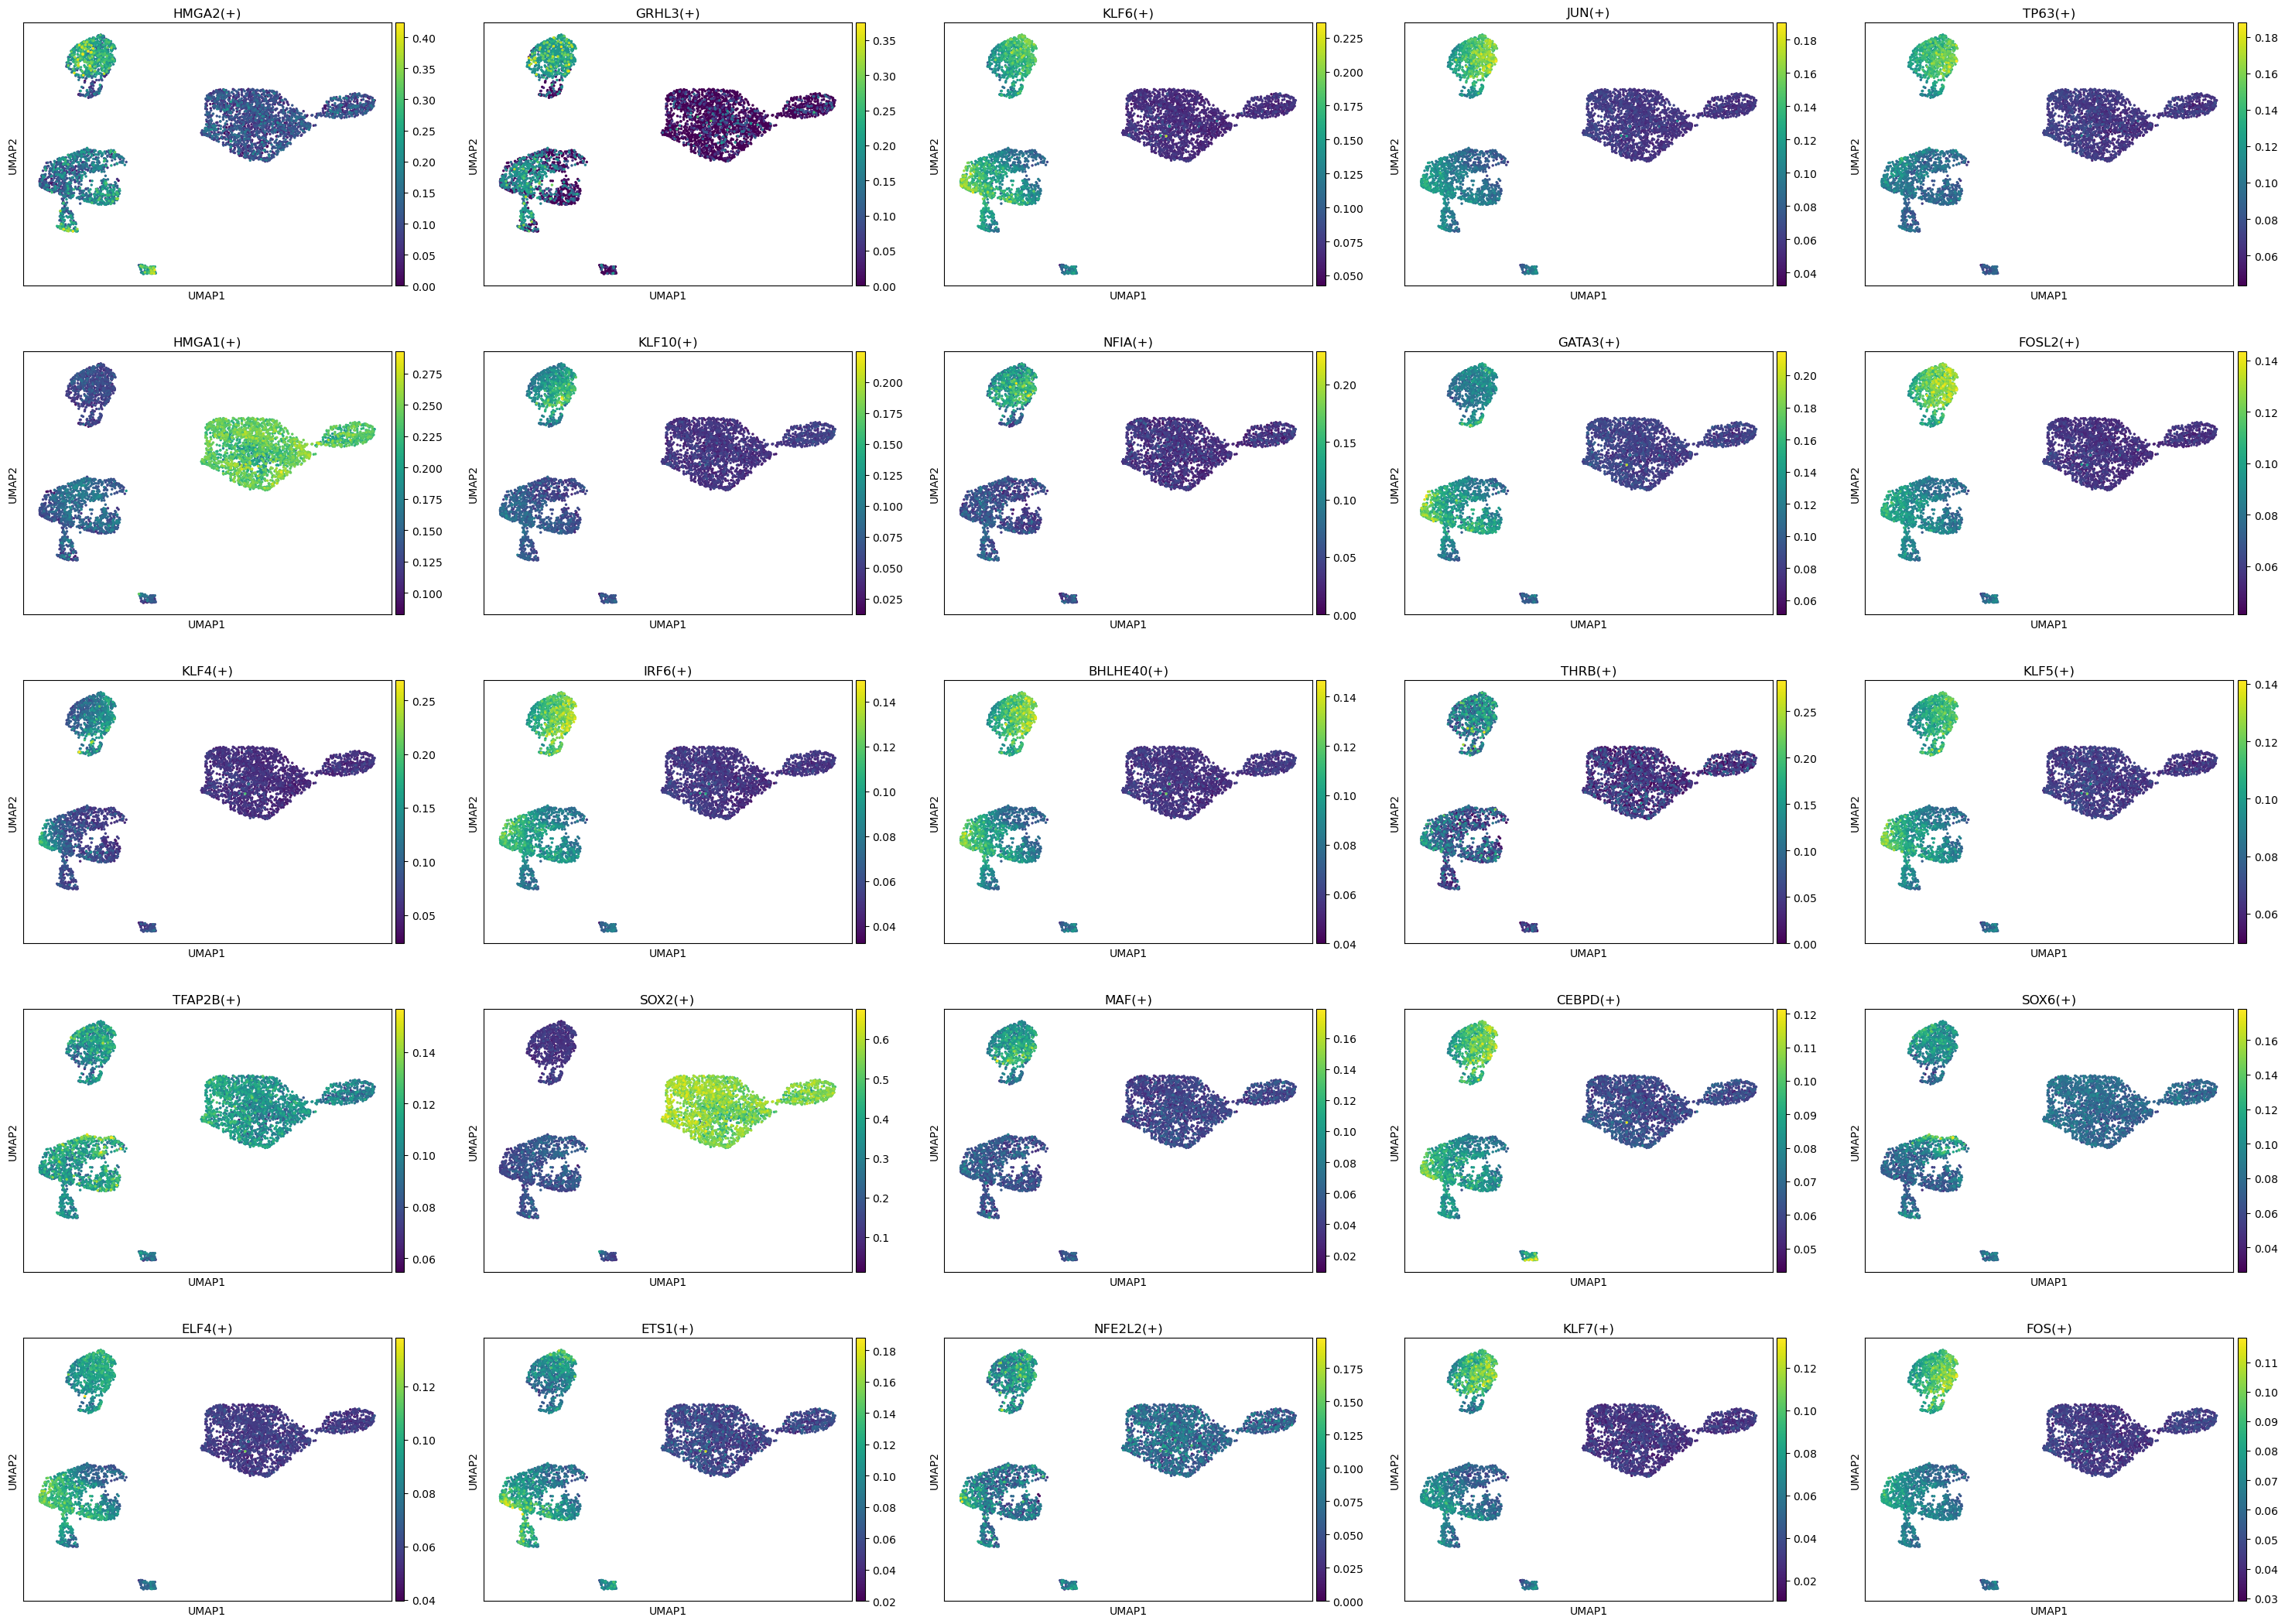

In [14]:
sc.pl.umap(adata, color=top_25_ilsc,ncols=5)

In [74]:
sc.write(f"{dir_disk}Radboud/data/scRNAseq_ipsc/correct/scenic_ipscs.h5ad",adata)

In [75]:
auc_mtx_cell_late = auc_mtx_cell[auc_mtx_cell["louvain"] == "late-epi"]
del auc_mtx_cell_late["louvain"]
auc_mtx_cell_late

ALX3(+)     AR(+)  \
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_K10   0.000000  0.000000   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_D7    0.000000  0.000000   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_H20   0.053541  0.000000   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_C17   0.017116  0.000000   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_A9    0.049663  0.000000   
...                                                      ...       ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r2_1...  0.063406  0.050169   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r2_1...  0.000000  0.000000   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.000000  0.000000   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.000000  0.000000   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.000000  0.000000   

                                                    ARID3A(+)  ARID5B(+)  \
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_K10    0.146037   0.018779   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_D7     0.154300   0.032572   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_H20    0.156830   0.032902   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_C17    0.105734   0.015333   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_A9     0.075717   0.018550   
...                                                       ...        ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r2_1...   0.000000   0.015049   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r2_1...   0.000000   0.026523   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.170826   0.039592   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.210793   0.011676   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000   0.027724   

                                                     ARNT(+)  ARNT2(+)  \
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_K10   0.013491  0.028831   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_D7    0.018153  0.007151   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_H20   0.015896  0.018916   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_C17   0.058303  0.025844   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_A9    0.007192  0.007902   
...                                                      ...       ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r2_1...  0.000000  0.017762   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r2_1...  0.000000  0.015108   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.000967  0.014638   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.017831  0.008131   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  0.000000  0.008513   

                                                    ARNTL2(+)  ASCL2(+)  \
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_K10    0.042861  0.000000   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_D7     0.039770  0.043939   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_H20    0.007097  0.000000   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_C17    0.000000  0.000000   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_A9     0.007940  0.000000   
...                                                       ...       ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r2_1...   0.000000  0.000000   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r2_1...   0.000000  0.000000   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000  0.028949   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000  0.000000   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...   0.000000  0.002623   

                                                     ATF1(+)   ATF3(+)  ...  \
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_K10   0.000527  0.057050  ...   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_D7    0.000000  0.053436  ...   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_H20   0.001555  0.040622  ...   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_C17   0.000000  0.040088  ...   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_A9    0.015072  0.03

In [76]:
auc_mtx_cell_late.sum().sort_values(ascending=False).head(25)

GCM1(+)       16.281197
KLF6(+)       12.645376
GATA3(+)      12.500013
KLF4(+)       11.877627
GATA2(+)      10.846130
ARID3A(+)     10.518718
HMGA1(+)      10.427457
SP6(+)        10.114433
SOX2(+)       10.004113
IRF6(+)        9.935779
TP63(+)        9.908181
JUN(+)         9.797226
KLF5(+)        9.521854
BHLHE40(+)     9.155454
SOX9(+)        9.134696
FOSL2(+)       8.843730
TFAP2B(+)      8.792143
CREB3L2(+)     8.560026
KLF10(+)       8.410496
HES2(+)        8.408094
MAFF(+)        8.259052
CEBPD(+)       8.053129
THRB(+)        8.013089
HMGA2(+)       7.924564
GRHL1(+)       7.901276
dtype: float64

In [77]:
top_25_late = auc_mtx_cell_late.sum().sort_values(ascending=False).head(25).index.to_list()

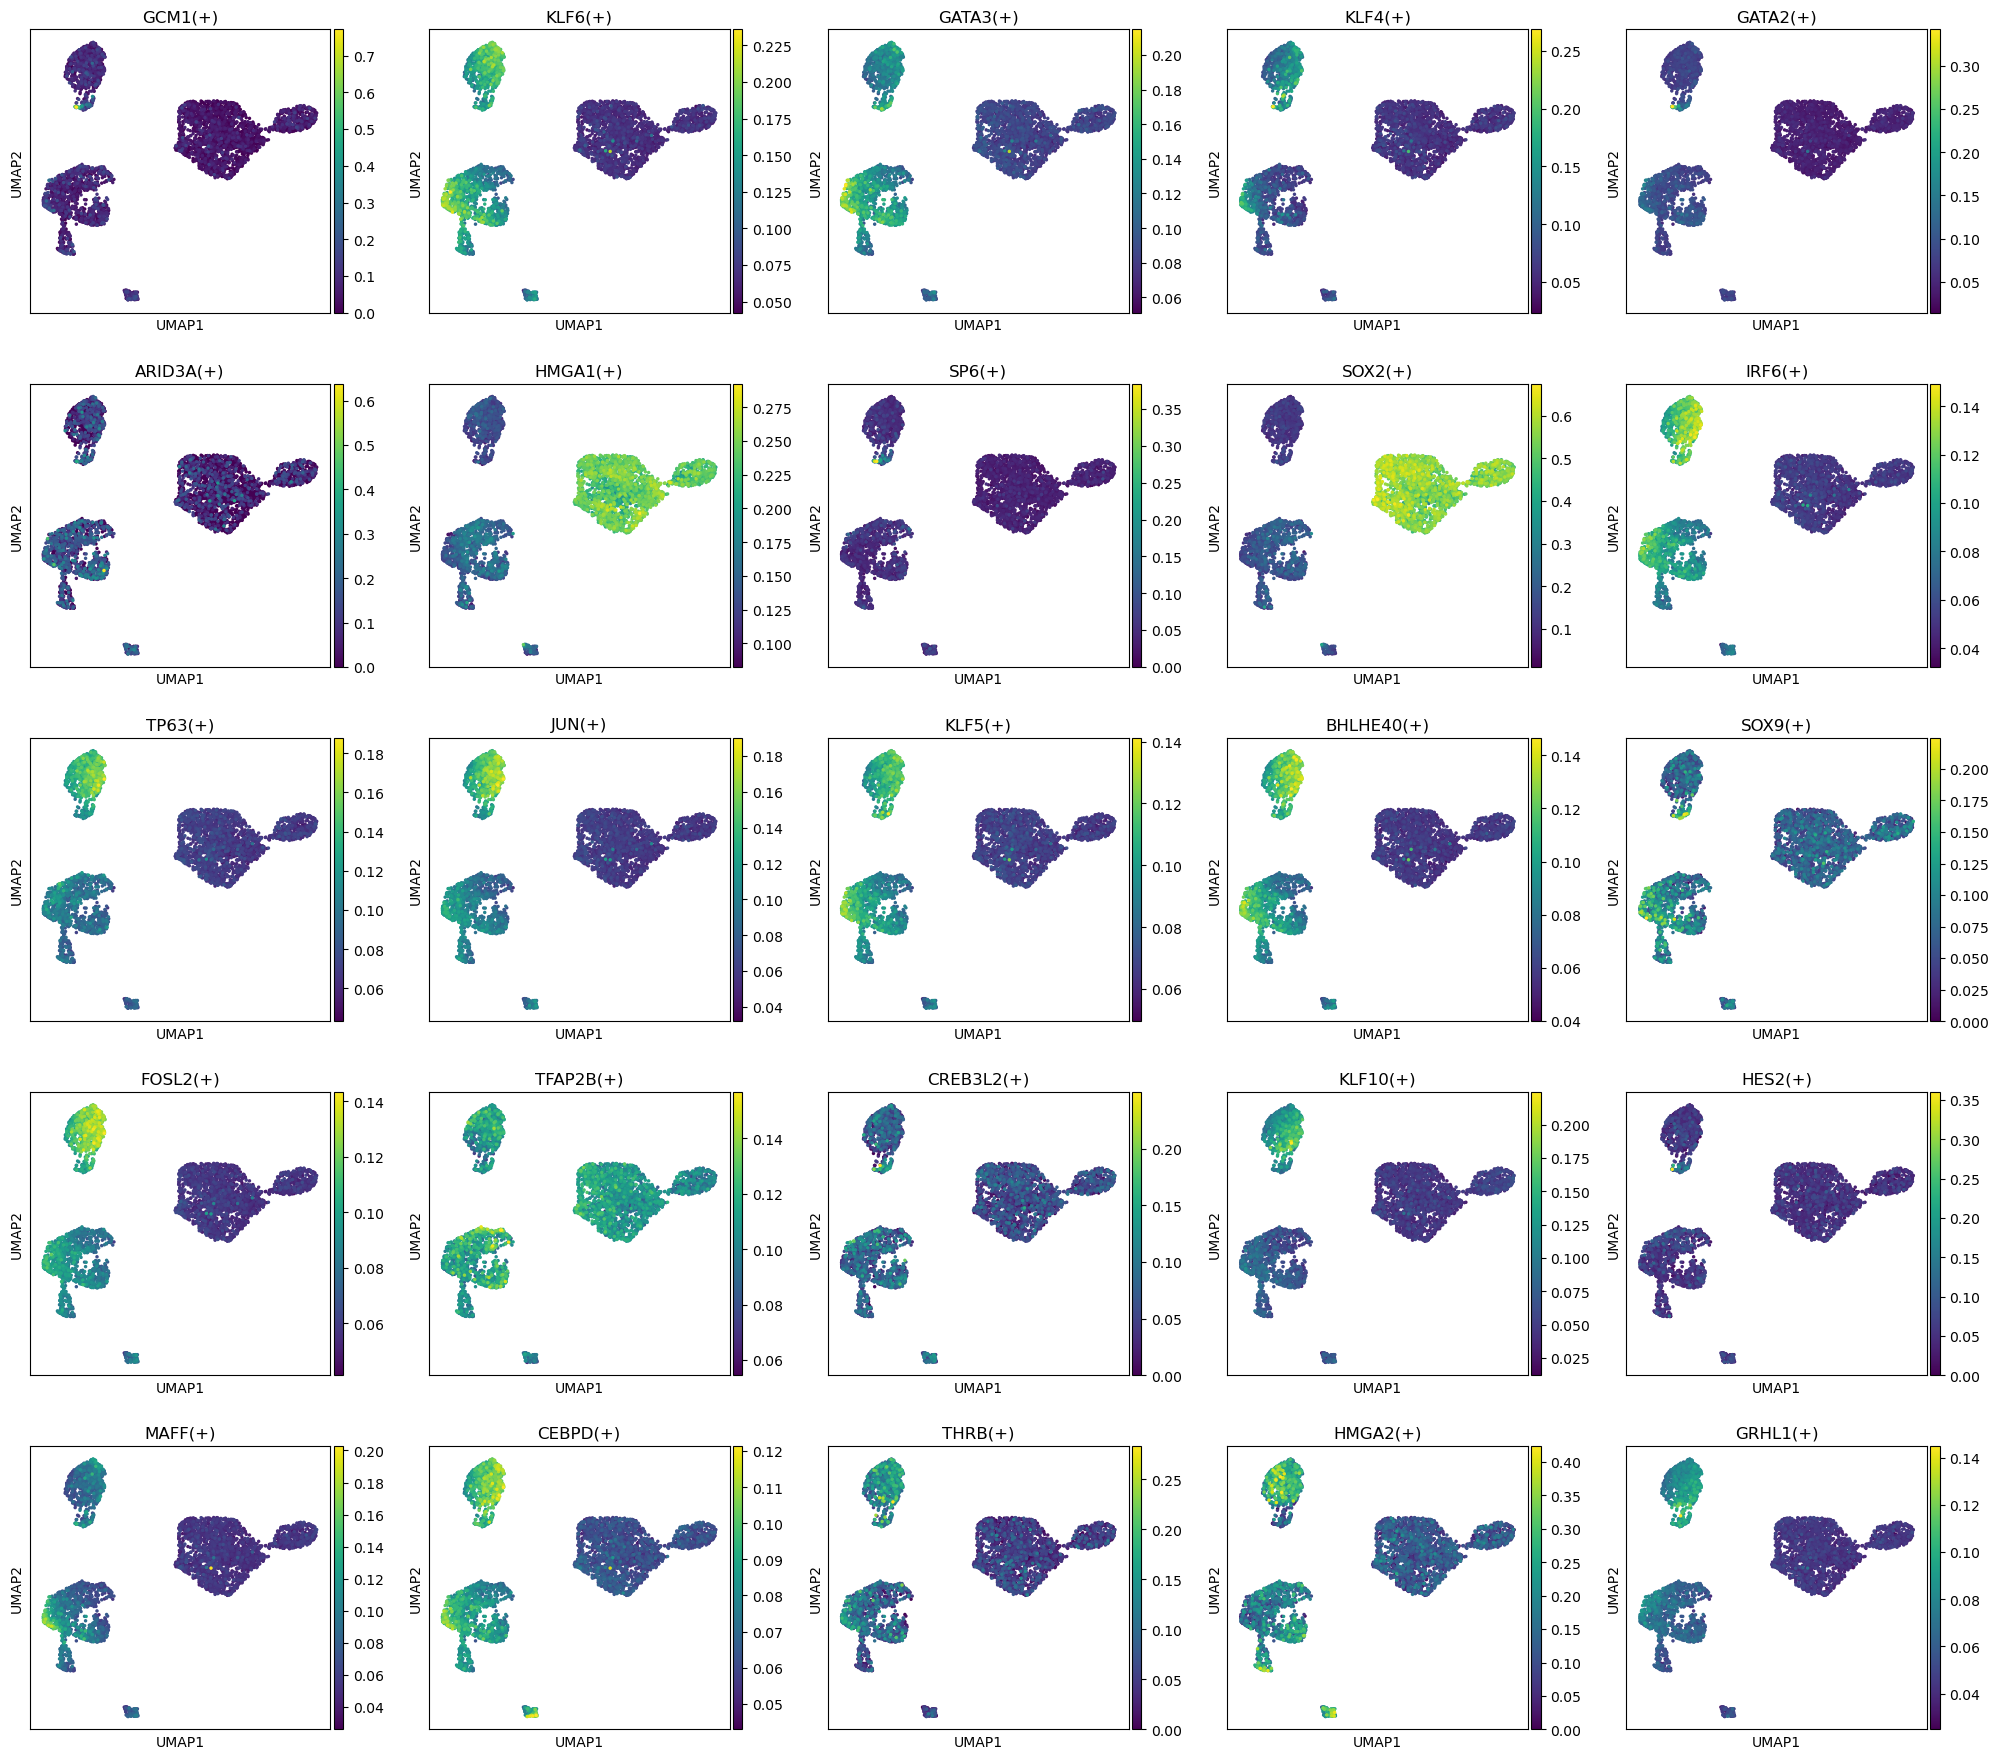

In [78]:
sc.pl.umap(adata, color=top_25_late,ncols=5)

In [79]:
sc.write(f"{dir_disk}Radboud/data/scRNAseq_ipsc/correct/scenic_late.h5ad",adata)

# Reading in the constructed object

In [46]:
adata = sc.read(f"{dir_disk}Radboud/data/scRNAseq_ipsc/correct/scenic_late.h5ad")

In [47]:
adata

AnnData object with n_obs × n_vars = 4840 × 23713
    obs: 'orig.ident', 'nCount_sf', 'nFeature_sf', 'sample', 'assembly', 'descriptive_name', 'cell_type', 'timepoint', 'batch', 'replica', 'medium', 'altexps_ERCC_percent', 'altexps_MT_percent', 'scDblFinder_doublet_score', 'scDblFinder_weighted', 'decontX_contamination', 'cell_type_time', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'sf_snn_res.0.4', 'seurat_clusters', 'sf_snn_res.0.1', 'sf_snn_res.0.2', 'sf_snn_res.0.3', 'sf_snn_res.0.5', 'sf_snn_res.0.6', 'sf_snn_res.0.7', 'sf_snn_res.0.8', 'sf_snn_res.0.9', 'sf_snn_res.1', 'sf_snn_res.1.1', 'sf_snn_res.1.2', 'sf_snn_res.1.3', 'sf_snn_res.1.4', 'sf_snn_res.1.5', 'sf_snn_res.1.6', 'sf_snn_res.1.7', 'sf_snn_res.1.8', 'sf_snn_res.1.9', 'sf_snn_res.2', 'cluster_names', 'louvain', 'ALX3(+)', 'AR(+)', 'ARID3A(+)', 'ARID5B(+)', 'ARNT(+)', 'ARNT2(+)', 'ARNTL2(+)', 'ASCL2(+)', 'ATF1(+)', 'ATF3(+)', 'ATF4(+)', 'ATF5(+)', 'ATF6(+)', 'ATF6B(+)', 'ATOH7(+)', 'BACH2(+)', 'BCL6B(+

In [48]:
# The raw counts contain the correct data
adata = adata.raw.to_adata()

In [49]:
top_25_late = ['GCM1(+)',
 'KLF6(+)',
 'GATA3(+)',
 'KLF4(+)',
 'GATA2(+)',
 'ARID3A(+)',
 'HMGA1(+)',
 'SP6(+)',
 'SOX2(+)',
 'IRF6(+)',
 'TP63(+)',
 'JUN(+)',
 'KLF5(+)',
 'BHLHE40(+)',
 'SOX9(+)',
 'FOSL2(+)',
 'TFAP2B(+)',
 'CREB3L2(+)',
 'KLF10(+)',
 'HES2(+)',
 'MAFF(+)',
 'CEBPD(+)',
 'THRB(+)',
 'HMGA2(+)',
 'GRHL1(+)']

In [50]:
top_25_ilsc= ["HMGA2(+)",
"GRHL3(+)",
"KLF6(+)",
"JUN(+)",
"TP63(+)",
"HMGA1(+)",
"KLF10(+)",
"NFIA(+)",
"GATA3(+)",
"FOSL2(+)",
"KLF4(+)",
"IRF6(+)",
"BHLHE40(+)",
"THRB(+)",
"KLF5(+)",
"TFAP2B(+)",
"SOX2(+)",
"MAF(+)",
"CEBPD(+)",
"SOX6(+)",
"ELF4(+)",
"ETS1(+)",
"NFE2L2(+)",
"KLF7(+)",
"FOS(+)"]

In [51]:
adata1 = adata[adata.obs["louvain"] == "iLSCs"]
adata1

View of AnnData object with n_obs × n_vars = 735 × 23713
    obs: 'orig.ident', 'nCount_sf', 'nFeature_sf', 'sample', 'assembly', 'descriptive_name', 'cell_type', 'timepoint', 'batch', 'replica', 'medium', 'altexps_ERCC_percent', 'altexps_MT_percent', 'scDblFinder_doublet_score', 'scDblFinder_weighted', 'decontX_contamination', 'cell_type_time', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'sf_snn_res.0.4', 'seurat_clusters', 'sf_snn_res.0.1', 'sf_snn_res.0.2', 'sf_snn_res.0.3', 'sf_snn_res.0.5', 'sf_snn_res.0.6', 'sf_snn_res.0.7', 'sf_snn_res.0.8', 'sf_snn_res.0.9', 'sf_snn_res.1', 'sf_snn_res.1.1', 'sf_snn_res.1.2', 'sf_snn_res.1.3', 'sf_snn_res.1.4', 'sf_snn_res.1.5', 'sf_snn_res.1.6', 'sf_snn_res.1.7', 'sf_snn_res.1.8', 'sf_snn_res.1.9', 'sf_snn_res.2', 'cluster_names', 'louvain', 'ALX3(+)', 'AR(+)', 'ARID3A(+)', 'ARID5B(+)', 'ARNT(+)', 'ARNT2(+)', 'ARNTL2(+)', 'ASCL2(+)', 'ATF1(+)', 'ATF3(+)', 'ATF4(+)', 'ATF5(+)', 'ATF6(+)', 'ATF6B(+)', 'ATOH7(+)', 'BACH2(+)', '

In [52]:
expression_list = [adata1[:,i].X.mean(0).item() for i in ["HMGA2",
"GRHL3",
"KLF6",
"JUN",
"TP63",
"HMGA1",
"KLF10",
"NFIA",
"GATA3",
"FOSL2",
"KLF4",
"IRF6",
"BHLHE40",
"THRB",
"KLF5",
"TFAP2B",
"SOX2",
"MAF",
"CEBPD",
"SOX6",
"ELF4",
"ETS1",
"NFE2L2",
"KLF7",
"FOS"]]
expression_list

[2.318957567203436,
 0.0029714528349989444,
 2.3268633160715373,
 1.4405840061941617,
 1.429602241503951,
 0.8584010046378604,
 0.9269260935448748,
 0.5221614020479953,
 1.0003069502945585,
 1.4722795311786248,
 0.5839567015191269,
 1.2157070426280756,
 0.821128780919499,
 0.7422473846275777,
 0.9190563332193777,
 0.3679032583875103,
 0.01410148921421113,
 0.16904127648245773,
 0.7466789545116141,
 0.38011309615028493,
 0.45136045213280174,
 0.455927291443977,
 0.9335720576648128,
 0.6741907366207995,
 1.0078473068444005]

In [53]:
adata1.obs

orig.ident  nCount_sf  \
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_G11            0     3723.0   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_D15            0     4715.0   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_K22            0     6186.0   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_F18            0     4947.0   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_G18            0     6790.0   
...                                                        ...        ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...           0     2705.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...           0     9686.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...           0     7027.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...           0     6490.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...           0     5937.0   

                                                    nFeature_sf  \
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_G11          1983   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_D15          2464   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_K22          2855   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_F18          2493   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_G18          2925   
...                                                         ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...         1705   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...         3477   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...         3137   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...         2904   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...         2817   

                                                                                 sample  \
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_G11                batch1_d24_1522_Z03_S6   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_D15                batch1_d24_1522_Z03_S6   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_K22                batch1_d24_1522_Z03_S6   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_F18                batch1_d24_1522_Z03_S6   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_G18                batch1_d24_1522_Z03_S6   
...                                                                                 ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  ext_batch3_d24_ESCs_r3_1688_Z22_S18   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  ext_batch3_d24_ESCs_r3_1688_Z22_S18   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  ext_batch3_d24_ESCs_r3_1688_Z22_S18   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  ext_batch3_d24_ESCs_r3_1688_Z22_S18   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  ext_batch3_d24_ESCs_r3_1688_Z22_S18   

                                                      assembly  \
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_G11   GRCh38.p13   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_D15   GRCh38.p13   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_K22   GRCh38.p13   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_F18   GRCh38.p13   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_G18   GRCh38.p13   
...                                                        ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  GRCh38.p13   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  GRCh38.p13   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  GRCh38.p13   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  GRCh38.p13   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  GRCh38.p13   

                                                   descriptive_name cell_type  \
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_G11        B2HT_d24_1      B2HT   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_D15        B2HT_d24_1      B2HT   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_K22        B2HT_d24_1      B2HT   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_F18        B2HT_d24_1      B2HT   
GRCh38.p13ERCCreporter_batch1_d

In [54]:
scenic_list=[adata1.obs[i].mean(0).item() for i in ["HMGA2(+)",
"GRHL3(+)",
"KLF6(+)",
"JUN(+)",
"TP63(+)",
"HMGA1(+)",
"KLF10(+)",
"NFIA(+)",
"GATA3(+)",
"FOSL2(+)",
"KLF4(+)",
"IRF6(+)",
"BHLHE40(+)",
"THRB(+)",
"KLF5(+)",
"TFAP2B(+)",
"SOX2(+)",
"MAF(+)",
"CEBPD(+)",
"SOX6(+)",
"ELF4(+)",
"ETS1(+)",
"NFE2L2(+)",
"KLF7(+)",
"FOS(+)"]]
scenic_list

[0.22245073858660944,
 0.1967473127530945,
 0.15888721075194903,
 0.13888011605996975,
 0.13679856774291851,
 0.12241174604766276,
 0.11989936410451217,
 0.11878018492388524,
 0.11618480090148592,
 0.11615220205473258,
 0.11495395606735985,
 0.11416188290263385,
 0.11232452426029847,
 0.10587755539058151,
 0.10315171406161747,
 0.10224628386517087,
 0.09645278492027987,
 0.09505100755194211,
 0.09484769150224306,
 0.09409142492223027,
 0.09166490834763542,
 0.09105110437197049,
 0.08832775144317066,
 0.08814376340755525,
 0.08740201610436192]

In [55]:
df = pd.DataFrame(list(zip(expression_list,scenic_list)),columns=["normalized mean expression score","scenic mean AUC score"])
df.index=["HMGA2",
"GRHL3",
"KLF6",
"JUN",
"TP63",
"HMGA1",
"KLF10",
"NFIA",
"GATA3",
"FOSL2",
"KLF4",
"IRF6",
"BHLHE40",
"THRB",
"KLF5",
"TFAP2B",
"SOX2",
"MAF",
"CEBPD",
"SOX6",
"ELF4",
"ETS1",
"NFE2L2",
"KLF7",
"FOS"]
df

normalized mean expression score  scenic mean AUC score
HMGA2                            2.318958               0.222451
GRHL3                            0.002971               0.196747
KLF6                             2.326863               0.158887
JUN                              1.440584               0.138880
TP63                             1.429602               0.136799
HMGA1                            0.858401               0.122412
KLF10                            0.926926               0.119899
NFIA                             0.522161               0.118780
GATA3                            1.000307               0.116185
FOSL2                            1.472280               0.116152
KLF4                             0.583957               0.114954
IRF6                             1.215707               0.114162
BHLHE40                          0.821129               0.112325
THRB                             0.742247               0.105878
KLF5                             0.919056               0.103152
TFAP2B                           0.367903               0.102246
SOX2                             0.014101               0.096453
MAF                              0.169041               0.095051
CEBPD                            0.746679               0.094848
SOX6                             0.380113               0.094091
ELF4                             0.451360               0.091665
ETS1                             0.455927               0.091051
NFE2L2                           0.933572               0.088328
KLF7                             0.674191               0.088144
FOS                              1.007847               0.087402

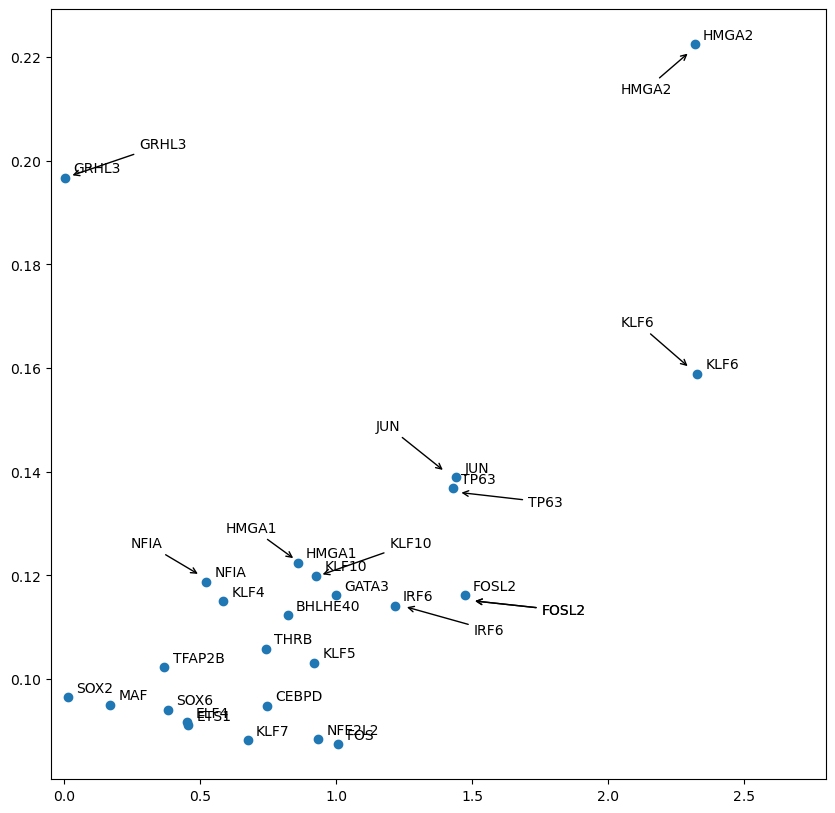

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize'] = [10, 10]

fig, ax = plt.subplots()
ax.scatter(df["normalized mean expression score"], df["scenic mean AUC score"])

for i, txt in enumerate(df.index):
    ax.annotate(txt, (df["normalized mean expression score"].iloc[i]+0.03, df["scenic mean AUC score"].iloc[i]+0.001))

ax.annotate(
    'HMGA2',
    xy=(2.3, 0.221), xycoords='data',
    xytext=(-50, -30), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'KLF6',
    xy=(2.3, 0.16), xycoords='data',
    xytext=(-50, 30), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'JUN',
    xy=(1.4, 0.14), xycoords='data',
    xytext=(-50, 30), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'TP63',
    xy=(1.45, 0.136), xycoords='data',
    xytext=(50, -10), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'FOSL2',
    xy=(1.5, 0.1151), xycoords='data',
    xytext=(50, -10), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'FOSL2',
    xy=(1.5, 0.1151), xycoords='data',
    xytext=(50, -10), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'IRF6',
    xy=(1.25, 0.114), xycoords='data',
    xytext=(50, -20), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'HMGA1',
    xy=(0.85, 0.123), xycoords='data',
    xytext=(-50, 20), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'GRHL3',
    xy=(0.02, 0.197), xycoords='data',
    xytext=(50, 20), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'NFIA',
    xy=(0.5, 0.12), xycoords='data',
    xytext=(-50, 20), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'KLF10',
    xy=(0.94, 0.12), xycoords='data',
    xytext=(50, 20), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

#plt.ylim(0,3610)
plt.xlim(-.05,2.8)

plt.show()

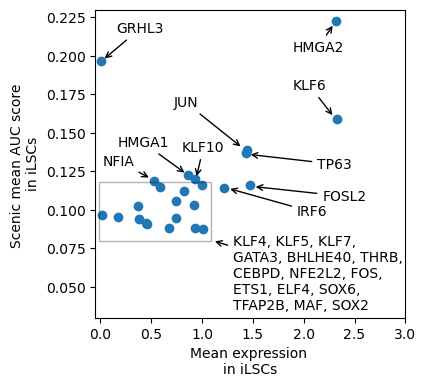

In [57]:
# Revised figure with correct spots, see above
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.patches import Rectangle

plt.rcParams['figure.figsize'] = [4, 4]

fig, ax = plt.subplots()
ax.scatter(df["normalized mean expression score"], df["scenic mean AUC score"])

ax.annotate(
    'HMGA2',
    xy=(2.3, 0.221), xycoords='data',
    xytext=(-30, -20), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'KLF6',
    xy=(2.3, 0.16), xycoords='data',
    xytext=(-30, 20), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'JUN',
    xy=(1.4, 0.14), xycoords='data',
    xytext=(-50, 30), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'TP63',
    xy=(1.45, 0.136), xycoords='data',
    xytext=(50, -10), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'FOSL2',
    xy=(1.5, 0.1151), xycoords='data',
    xytext=(50, -10), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'IRF6',
    xy=(1.25, 0.114), xycoords='data',
    xytext=(50, -20), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'HMGA1',
    xy=(0.85, 0.123), xycoords='data',
    xytext=(-50, 20), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'GRHL3',
    xy=(0.02, 0.197), xycoords='data',
    xytext=(10, 20), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'NFIA',
    xy=(0.5, 0.12), xycoords='data',
    xytext=(-35, 10), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'KLF10',
    xy=(0.94, 0.12), xycoords='data',
    xytext=(-10, 20), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    "KLF4, KLF5, KLF7, \nGATA3, BHLHE40, THRB, \nCEBPD, NFE2L2, FOS, \nETS1, ELF4, SOX6, \nTFAP2B, MAF, SOX2",
    xy=(1.1, 0.08), xycoords='data',
    xytext=(15, -50), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

someX, someY = 0.1, 0.1
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((someX - .11, someY - .02), 1.1, 0.038, fill=False, alpha=0.3))

plt.ylim(0.03,0.23)
plt.xlim(-.05,3)
plt.xlabel("Mean expression \nin iLSCs")
plt.ylabel("Scenic mean AUC score \nin iLSCs")

plt.savefig("ipscs_scenic.pdf")

plt.show()

In [58]:
top_25_late = ['GCM1(+)',
 'KLF6(+)',
 'GATA3(+)',
 'KLF4(+)',
 'GATA2(+)',
 'ARID3A(+)',
 'HMGA1(+)',
 'SP6(+)',
 'SOX2(+)',
 'IRF6(+)',
 'TP63(+)',
 'JUN(+)',
 'KLF5(+)',
 'BHLHE40(+)',
 'SOX9(+)',
 'FOSL2(+)',
 'TFAP2B(+)',
 'CREB3L2(+)',
 'KLF10(+)',
 'HES2(+)',
 'MAFF(+)',
 'CEBPD(+)',
 'THRB(+)',
 'HMGA2(+)',
 'GRHL1(+)']

In [59]:
adata2 = adata[adata.obs["louvain"] == "late-epi"]
adata2

View of AnnData object with n_obs × n_vars = 91 × 23713
    obs: 'orig.ident', 'nCount_sf', 'nFeature_sf', 'sample', 'assembly', 'descriptive_name', 'cell_type', 'timepoint', 'batch', 'replica', 'medium', 'altexps_ERCC_percent', 'altexps_MT_percent', 'scDblFinder_doublet_score', 'scDblFinder_weighted', 'decontX_contamination', 'cell_type_time', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'sf_snn_res.0.4', 'seurat_clusters', 'sf_snn_res.0.1', 'sf_snn_res.0.2', 'sf_snn_res.0.3', 'sf_snn_res.0.5', 'sf_snn_res.0.6', 'sf_snn_res.0.7', 'sf_snn_res.0.8', 'sf_snn_res.0.9', 'sf_snn_res.1', 'sf_snn_res.1.1', 'sf_snn_res.1.2', 'sf_snn_res.1.3', 'sf_snn_res.1.4', 'sf_snn_res.1.5', 'sf_snn_res.1.6', 'sf_snn_res.1.7', 'sf_snn_res.1.8', 'sf_snn_res.1.9', 'sf_snn_res.2', 'cluster_names', 'louvain', 'ALX3(+)', 'AR(+)', 'ARID3A(+)', 'ARID5B(+)', 'ARNT(+)', 'ARNT2(+)', 'ARNTL2(+)', 'ASCL2(+)', 'ATF1(+)', 'ATF3(+)', 'ATF4(+)', 'ATF5(+)', 'ATF6(+)', 'ATF6B(+)', 'ATOH7(+)', 'BACH2(+)', 'B

In [60]:
expression_list = [adata2[:,i].X.mean(0).item() for i in ['GCM1', 'KLF6', 'GATA3', 'KLF4', 'GATA2', 'ARID3A', 'HMGA1', 'SP6', 'SOX2', 'IRF6', 'TP63', 'JUN', 'KLF5', 'BHLHE40', 'SOX9', 'FOSL2', 'TFAP2B', 'CREB3L2', 'KLF10', 'HES2', 'MAFF', 'CEBPD', 'THRB', 'HMGA2', 'GRHL1']]
expression_list

[0.2029911704790253,
 2.033073210602857,
 1.8435209498742728,
 0.8272507740485259,
 0.5544163212141748,
 1.4805302332796024,
 0.7497544978640878,
 0.45351856574089916,
 0.1100862954485704,
 1.3901183307581204,
 0.4529346027605673,
 0.850392999896524,
 1.4755196916728497,
 0.8780802012295725,
 0.9402756995565236,
 1.110288170294134,
 0.3391981526505494,
 1.5502888468812972,
 0.7467912319865703,
 0.5488681136318626,
 0.2942047316380128,
 0.991733504222804,
 0.5660916960148809,
 0.7903546687066291,
 0.8940948143367388]

In [61]:
adata2.obs

orig.ident  nCount_sf  \
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_K10            0     1902.0   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_D7             0     4940.0   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_H20            0     1457.0   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_C17            0     2898.0   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_A9             0     1390.0   
...                                                        ...        ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r2_1...           0     2689.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r2_1...           0     3783.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...           0     5862.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...           0     4708.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...           0     2947.0   

                                                    nFeature_sf  \
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_K10          1118   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_D7           2278   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_H20          1078   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_C17          1760   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_A9           1065   
...                                                         ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r2_1...         1652   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r2_1...         1927   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...         2607   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...         2304   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...         1792   

                                                                                 sample  \
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_K10                batch1_d24_1522_Z03_S6   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_D7                 batch1_d24_1522_Z03_S6   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_H20                batch1_d24_1522_Z03_S6   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_C17                batch1_d24_1522_Z03_S6   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_A9                 batch1_d24_1522_Z03_S6   
...                                                                                 ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r2_1...  ext_batch3_d24_ESCs_r2_1661_Z21_S17   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r2_1...  ext_batch3_d24_ESCs_r2_1661_Z21_S17   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  ext_batch3_d24_ESCs_r3_1688_Z22_S18   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  ext_batch3_d24_ESCs_r3_1688_Z22_S18   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  ext_batch3_d24_ESCs_r3_1688_Z22_S18   

                                                      assembly  \
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_K10   GRCh38.p13   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_D7    GRCh38.p13   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_H20   GRCh38.p13   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_C17   GRCh38.p13   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_A9    GRCh38.p13   
...                                                        ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r2_1...  GRCh38.p13   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r2_1...  GRCh38.p13   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  GRCh38.p13   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  GRCh38.p13   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  GRCh38.p13   

                                                   descriptive_name cell_type  \
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_K10        B2HT_d24_1      B2HT   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_D7         B2HT_d24_1      B2HT   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_H20        B2HT_d24_1      B2HT   
GRCh38.p13ERCCreporter_batch1_d24_1522_Z03_S6_C17        B2HT_d24_1      B2HT   
GRCh38.p13ERCCreporter_batch1_d

In [62]:
scenic_list=[adata2.obs[i].mean(0).item() for i in ['GCM1(+)',
 'KLF6(+)',
 'GATA3(+)',
 'KLF4(+)',
 'GATA2(+)',
 'ARID3A(+)',
 'HMGA1(+)',
 'SP6(+)',
 'SOX2(+)',
 'IRF6(+)',
 'TP63(+)',
 'JUN(+)',
 'KLF5(+)',
 'BHLHE40(+)',
 'SOX9(+)',
 'FOSL2(+)',
 'TFAP2B(+)',
 'CREB3L2(+)',
 'KLF10(+)',
 'HES2(+)',
 'MAFF(+)',
 'CEBPD(+)',
 'THRB(+)',
 'HMGA2(+)',
 'GRHL1(+)']]
scenic_list

[0.17891425606434036,
 0.13896017919277537,
 0.13736278018511003,
 0.1305233698774281,
 0.11918823756672592,
 0.11559031188036246,
 0.1145874438689943,
 0.11114761402539097,
 0.1099353033654579,
 0.10918438713409341,
 0.1088811089459682,
 0.10766182943488044,
 0.10463576139475224,
 0.10060938953156512,
 0.10038127976576545,
 0.09718384359756983,
 0.09661695125438803,
 0.09406621644636583,
 0.09242303153332676,
 0.09239664214369105,
 0.09075881178988864,
 0.08849591968588962,
 0.0880559254445065,
 0.0870831248571552,
 0.08682720435430627]

In [63]:
df = pd.DataFrame(list(zip(expression_list,scenic_list)),columns=["normalized mean expression score","scenic mean AUC score"])
df.index=['GCM1', 'KLF6', 'GATA3', 'KLF4', 'GATA2', 'ARID3A', 'HMGA1', 'SP6', 'SOX2', 'IRF6', 'TP63', 'JUN', 'KLF5', 'BHLHE40', 'SOX9', 'FOSL2', 'TFAP2B', 'CREB3L2', 'KLF10', 'HES2', 'MAFF', 'CEBPD', 'THRB', 'HMGA2', 'GRHL1']
df

normalized mean expression score  scenic mean AUC score
GCM1                             0.202991               0.178914
KLF6                             2.033073               0.138960
GATA3                            1.843521               0.137363
KLF4                             0.827251               0.130523
GATA2                            0.554416               0.119188
ARID3A                           1.480530               0.115590
HMGA1                            0.749754               0.114587
SP6                              0.453519               0.111148
SOX2                             0.110086               0.109935
IRF6                             1.390118               0.109184
TP63                             0.452935               0.108881
JUN                              0.850393               0.107662
KLF5                             1.475520               0.104636
BHLHE40                          0.878080               0.100609
SOX9                             0.940276               0.100381
FOSL2                            1.110288               0.097184
TFAP2B                           0.339198               0.096617
CREB3L2                          1.550289               0.094066
KLF10                            0.746791               0.092423
HES2                             0.548868               0.092397
MAFF                             0.294205               0.090759
CEBPD                            0.991734               0.088496
THRB                             0.566092               0.088056
HMGA2                            0.790355               0.087083
GRHL1                            0.894095               0.086827

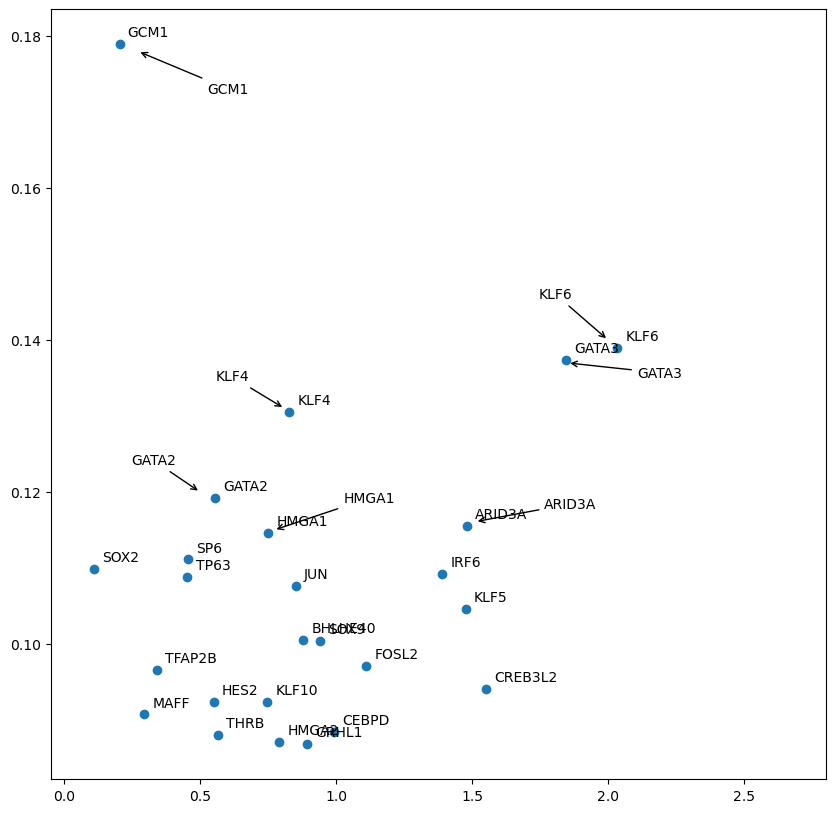

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams['figure.figsize'] = [10, 10]

fig, ax = plt.subplots()
ax.scatter(df["normalized mean expression score"], df["scenic mean AUC score"])

for i, txt in enumerate(df.index):
    ax.annotate(txt, (df["normalized mean expression score"].iloc[i]+0.03, df["scenic mean AUC score"].iloc[i]+0.001))

ax.annotate(
    'GCM1',
    xy=(0.27, 0.178), xycoords='data',
    xytext=(50, -30), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'KLF6',
    xy=(2.0, 0.14), xycoords='data',
    xytext=(-50, 30), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'GATA3',
    xy=(1.85, 0.137), xycoords='data',
    xytext=(50, -10), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'ARID3A',
    xy=(1.51, 0.1161), xycoords='data',
    xytext=(50, 10), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'HMGA1',
    xy=(0.77, 0.115), xycoords='data',
    xytext=(50, 20), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'KLF4',
    xy=(0.81, 0.131), xycoords='data',
    xytext=(-50, 20), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'GATA2',
    xy=(0.5, 0.12), xycoords='data',
    xytext=(-50, 20), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))


plt.xlim(-.05,2.8)

plt.show()

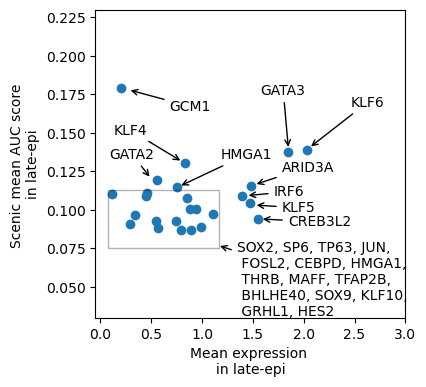

In [65]:
# Nice version of the plot above
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib.patches import Rectangle

plt.rcParams['figure.figsize'] = [4, 4]

fig, ax = plt.subplots()
ax.scatter(df["normalized mean expression score"], df["scenic mean AUC score"])

ax.annotate(
    'GCM1',
    xy=(0.27, 0.178), xycoords='data',
    xytext=(30, -15), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'KLF6',
    xy=(2.05, 0.14), xycoords='data',
    xytext=(30, 30), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'GATA3',
    xy=(1.85, 0.139), xycoords='data',
    xytext=(-20, 40), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'ARID3A',
    xy=(1.51, 0.1161), xycoords='data',
    xytext=(20, 10), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'HMGA1',
    xy=(0.77, 0.115), xycoords='data',
    xytext=(30, 20), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'KLF4',
    xy=(0.81, 0.131), xycoords='data',
    xytext=(-50, 20), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'GATA2',
    xy=(0.5, 0.12), xycoords='data',
    xytext=(-30, 15), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'IRF6',
    xy=(1.43, 0.1091), xycoords='data',
    xytext=(20, 0), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'KLF5',
    xy=(1.51, 0.1031), xycoords='data',
    xytext=(20, -5), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    'CREB3L2',
    xy=(1.57, 0.094), xycoords='data',
    xytext=(20, -5), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

ax.annotate(
    "SOX2, SP6, TP63, JUN,\n FOSL2, CEBPD, HMGA1,\n THRB, MAFF, TFAP2B, \n BHLHE40, SOX9, KLF10,\n GRHL1, HES2",
    xy=(1.15, 0.077), xycoords='data',
    xytext=(14, -51), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"))

someX, someY = 0.1, 0.1
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((someX - .03, someY - .025), 1.1, 0.038, fill=False, alpha=0.3))

plt.ylim(0.03,0.23)
plt.xlim(-.05,3)
plt.xlabel("Mean expression \nin late-epi")
plt.ylabel("Scenic mean AUC score \nin late-epi")

plt.savefig("late_scenic.pdf")

plt.show()


# Plotting scenic scores on the UMAP

In [66]:
# Replace SCENICs standard (+)
adata.obs.columns = adata.obs.columns.str.replace("(+)", " (SCENIC score)")#, regex=True)

In [67]:
adata.obs

orig.ident  nCount_sf  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18             0     3765.0   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24             0     5799.0   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22             0     6716.0   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15             0     6138.0   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_J17             0     5670.0   
...                                                        ...        ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...           0     2705.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...           0     9686.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...           0     7027.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...           0     6490.0   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...           0     5937.0   

                                                    nFeature_sf  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18           2188   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24           2916   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22           3258   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15           2947   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_J17           2802   
...                                                         ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...         1705   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...         3477   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...         3137   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...         2904   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...         2817   

                                                                                 sample  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18                  batch1_d0_1523_Z04_S7   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24                  batch1_d0_1523_Z04_S7   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22                  batch1_d0_1523_Z04_S7   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15                  batch1_d0_1523_Z04_S7   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_J17                  batch1_d0_1523_Z04_S7   
...                                                                                 ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  ext_batch3_d24_ESCs_r3_1688_Z22_S18   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  ext_batch3_d24_ESCs_r3_1688_Z22_S18   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  ext_batch3_d24_ESCs_r3_1688_Z22_S18   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  ext_batch3_d24_ESCs_r3_1688_Z22_S18   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  ext_batch3_d24_ESCs_r3_1688_Z22_S18   

                                                      assembly  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18    GRCh38.p13   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24    GRCh38.p13   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22    GRCh38.p13   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15    GRCh38.p13   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_J17    GRCh38.p13   
...                                                        ...   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  GRCh38.p13   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  GRCh38.p13   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  GRCh38.p13   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  GRCh38.p13   
GRCh38.p13ERCCreporter_ext_batch3_d24_ESCs_r3_1...  GRCh38.p13   

                                                   descriptive_name cell_type  \
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_O18          B2HT_d0_1      B2HT   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N24          B2HT_d0_1      B2HT   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_N22          B2HT_d0_1      B2HT   
GRCh38.p13ERCCreporter_batch1_d0_1523_Z04_S7_L15          B2HT_d0_1      B2HT   
GRCh38.p13ERCCreporter_batch1_d

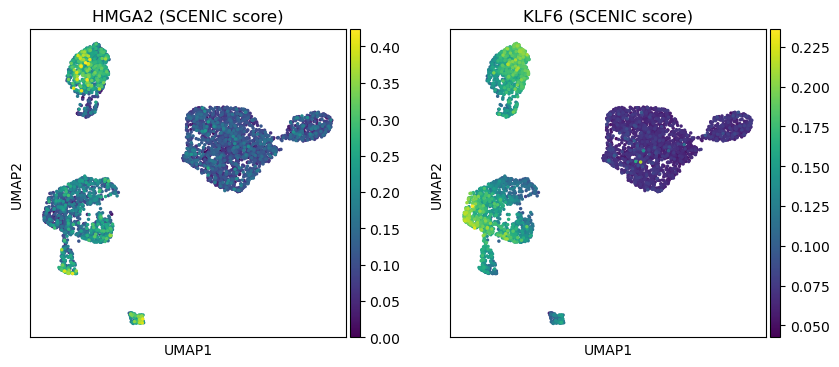

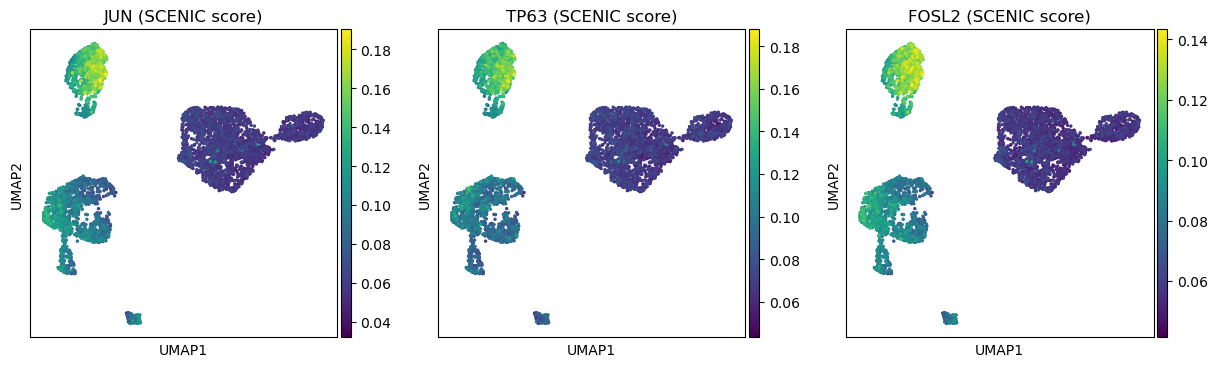

In [70]:
# Selection for iLSCs
plt.rcParams['figure.figsize'] = [4, 4]
sc.pl.umap(adata, color=["HMGA2 (SCENIC score)","KLF6 (SCENIC score)"],ncols=2, save='ilscs_scenic_umaps.pdf')
sc.pl.umap(adata, color=["JUN (SCENIC score)","TP63 (SCENIC score)","FOSL2 (SCENIC score)"],ncols=3, save='ilscs_scenic_umaps2.pdf')

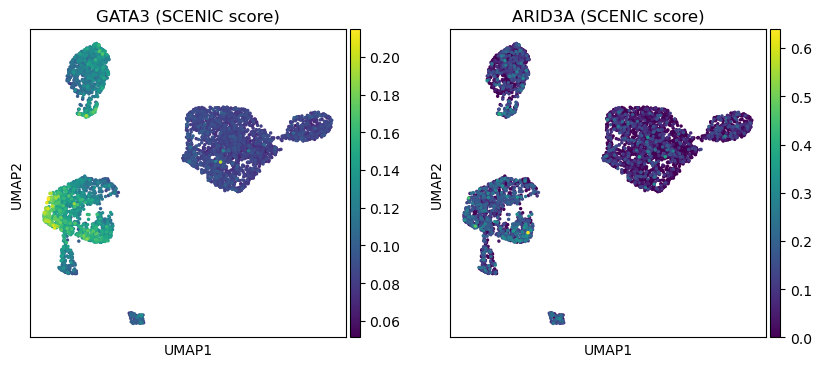

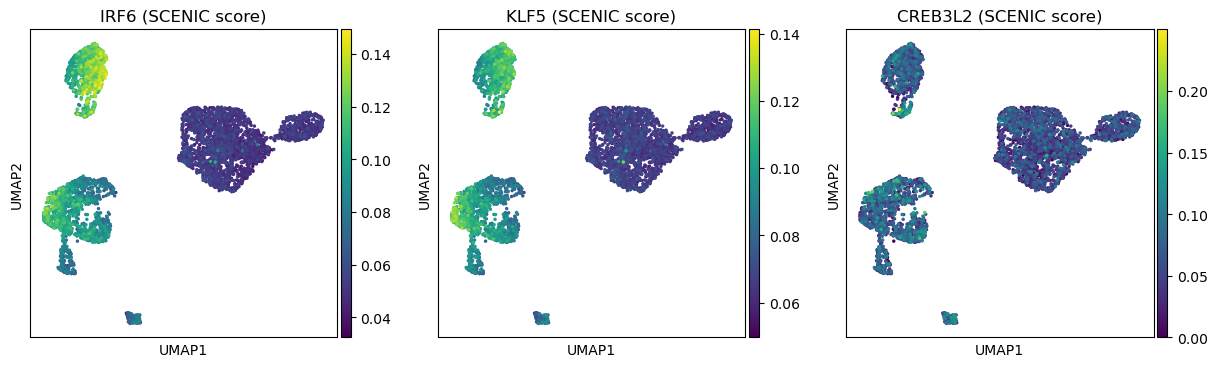

In [69]:
# Selection for late-epi
plt.rcParams['figure.figsize'] = [4, 4]
sc.pl.umap(adata, color=["GATA3 (SCENIC score)","ARID3A (SCENIC score)"],ncols=2, save='late_scenic_umaps.pdf')
sc.pl.umap(adata, color=["IRF6 (SCENIC score)","KLF5 (SCENIC score)","CREB3L2 (SCENIC score)"],ncols=3, save='late_scenic_umaps2.pdf')